# 한글 Word2Vec 만들기

In [1]:
# KoNLP 성치
!pip install konlpy

     |████████████████████████████████| 19.4 MB 36.6 MB/s 
     |████████████████████████████████| 448 kB 24.7 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", sep='\t')
df.head(3)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1


### 데이터 전처리

In [4]:
# 중복 여부 확인
df.shape, df['document'].nunique()

((200000, 3), 194543)

In [5]:
# 중복 데이터 배제
df.drop_duplicates(subset=['document'], inplace=True)
df.shape

(194544, 3)

In [6]:
# Null 데이터 유무 확인
df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [7]:
# Null 데이터 제거
df.dropna(how='any', inplace=True)

In [8]:
# 한글 이외의 문자는 공백으로 처리하고 strip
df.document = df.document.str.replace('[^ㄱ-하-ㅣ-가-힣]',' ').str.strip()
df.head(3)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 생으로 외국디자이너와 그들이 일군 전통을 통 발전 가는 문 산...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1


In [10]:
# ''만 남은 데이터 --> np.nan으로 변경시킨 후 제거
df.document.replace('', np.nan, inplace=True)
df.document.isna().sum()

1033

In [11]:
# Null 데이터 제거
df.dropna(how='any', inplace=True)
df.shape

(193510, 3)

### 한글 형태소 분석

In [12]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','.',',','?','!','\'','"']

In [13]:
okt = Okt()
print(okt.morphs('토큰화가 된 상태에서는 각 리뷰의 길이 분포 또한 확인이 가능합니다.'))

['토큰', '화가', '된', '상태', '에서는', '각', '리뷰', '의', '길이', '분포', '또한', '확인', '이', '가능합니다', '.']


In [14]:
print(okt.morphs('토큰화가 된 상태에서는 각 리뷰의 길이 분포 또한 확인이 가능합니다.', stem=True))

['토큰', '화가', '되다', '상태', '에서는', '각', '리뷰', '의', '길이', '분포', '또한', '확인', '이', '가능하다', '.']


In [15]:
from tqdm.notebook import tqdm

tokenized_data = []
for sentence in tqdm(df.document):
  morphs = okt.morphs(sentence, stem=True)
  morphs = [word for word in morphs if word not in stopwords] # 불용어 제거
  tokenized_data.append(morphs)

  0%|          | 0/193510 [00:00<?, ?it/s]

리뷰의 최대 길이 : 71
리뷰의 평균 길이 : 11.24755309803111


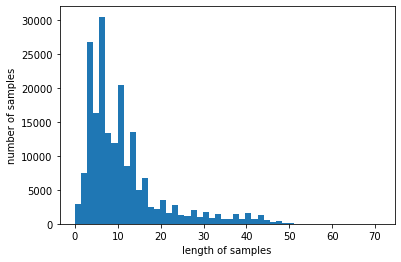

In [16]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Word2Vec 훈련시키기

In [17]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [18]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(15136, 100)

In [19]:
model.wv.most_similar("최민식", topn=5)

[('최민수', 0.8667758107185364),
 ('크로우', 0.8486874103546143),
 ('루이스', 0.8396197557449341),
 ('양동근', 0.8364313244819641),
 ('이민', 0.8362529277801514)]

In [20]:
model.wv.most_similar("히어로", topn=5)

KeyError: ignored

In [21]:
# 한국 - 서울 + 도쿄
# 영화평으로 학습을 해서 올바른 결과가 나오지 않음
model.wv.most_similar(positive=['한국', '도쿄'], negative=['서울'], topn=3)

KeyError: ignored

In [22]:
# 황정민 - 느와르 + 멜로
model.wv.most_similar(positive=['황정민', '멜로'], negative=['느와르'])

KeyError: ignored